# Document Similarity Graph Generation

## TODO
 * Improve graph interactivity.
 * Display both ground truth and votes in graph.
 * Explore using simhashing to speed up the similarity lookups

In [2]:
from graphviz import Digraph, Graph

import numpy as np
from sklearn.feature_extraction.text import *
from sklearn.metrics.pairwise import cosine_similarity

import datetime
import io
import random
import os

In [3]:
random.seed(0xC0FFEE)

In [4]:
%run ../data.py
%run ../config.py

## Load the topic information for improved manual inspection

In [5]:
TOPIC_DESCRIPTION_FILE = os.path.join(DATA_ROOT, 'topics.mq09.cs2011-test-topics.xml')

In [6]:
import xml.etree.ElementTree

class Topic(object):
    required = ['number', 'query']
    
    def __init__(self, entries):
        for field in self.required:
            assert field in entries.keys()
            
        self.__dict__.update(entries)
        
    def __repr__(self):
        return "%s:%s" % (self.number, self.query)

xml_root = xml.etree.ElementTree.parse(TOPIC_DESCRIPTION_FILE).getroot()
topic_info = [Topic({field.attrib['name'] : field.text for field in row}) for row in xml_root]
id_topic_info = {topic.number : topic for topic in topic_info}

## Load the relevance judgements to improve the visualization

In [7]:
# Turk judgements
judgements = read_useful_judgement_labels(JUDGEMENT_FILE)

# Ground truth
# Note: it seems to be normal that there are duplicates in this dataset.
test_data = read_expert_labels(TEST_LABEL_FILE_SHARED, header=True, sep=',') + \
    read_expert_labels(TEST_LABEL_FILE_TEAMS, header=True, sep=',')

In [8]:
topics = { l.topic_id for l in judgements }

# Some topic ID we want to visualize.
target_topic_id = '20704'
assert target_topic_id in topics
print("Topic we are exploring: [%s]" % id_topic_info[target_topic_id])

Topic we are exploring: [20704:detroit riot]


In [9]:
topic_judgements = [j for j in judgements if j.topic_id == target_topic_id]
doc_ids_in_topic = {j.doc_id for j in topic_judgements}
print("%d turk judgements in topic [%s] of %d documents." % (len(topic_judgements), target_topic_id, len(doc_ids_in_topic)))
print("AVG: %.2f judgements per documents" % (len(topic_judgements) / len(doc_ids_in_topic)))

465 turk judgements in topic [20704] of 90 documents.
AVG: 5.17 judgements per documents


In [10]:
topic_judgements_by_doc_id = {}

for j in topic_judgements:
    if j.doc_id not in topic_judgements_by_doc_id:
        topic_judgements_by_doc_id[j.doc_id] = []
        
    topic_judgements_by_doc_id[j.doc_id].append(j)

## Load the document data

In [11]:
FULLTEXT_FOLDER = os.path.join(DATA_ROOT, 'url-header-html-txt')

In [12]:
topic_folder = os.path.join(FULLTEXT_FOLDER, str(target_topic_id))

In [13]:
# Grab every file from the topic, and only look at those whose
# names end in '.txt', i.e. the HTML text with all HTML tags stripped
# away.
file_names = [f for f in os.listdir(topic_folder) 
                 if os.path.isfile(os.path.join(topic_folder, f))
                 and f.endswith(".txt")]
print("We have %d files." % len(file_names))

We have 141 files.


In [14]:
def read_file(name):
    with io.open(name, 'r') as file:
        return file.read()
    
    
# A map of file names (IDs) to their contents.
doc_id_to_doc = {}
corpus = []

for f in file_names:
    doc_id = f[:f.rfind('.')]
    text = read_file(os.path.join(topic_folder, f))
    doc_id_to_doc[doc_id] = text
    corpus.append((doc_id, text))

In [15]:
class DocumentEdge(object):
    """ Represents an edge in the document similarity graph.
    
    """
    def __init__(self, from_document_id, to_document_id, similarity):
        self.from_document_id = from_document_id
        self.to_document_id = to_document_id
        self.similarity = similarity


class DocumentNode(object):
    """ Represents a node (a document) in the document similarity graph.
    
    Attributes:
        topic_id: The int ID of the topic to which the document belongs.
        document_id: The ID of the document, without any file extension.
        document_name: The full name of the document (usually its ID, plus
            its extension).
        neighbors: A list of 'DocumentEdge' objects, representing this
            node's neighbors.
    """
    def __init__(self, topic_id, document_id, document_name, neighbors):
        self.topic_id = topic_id
        self.document_id = document_id
        self.document_name = document_name
        self.neighbors = neighbors

In [16]:
class DocumentGraph(object):
    """ Represents a graph with documents as nodes, and similarities as
    edges.
    
    """
    
    def __init__(self, topic, nodes):
        self.nodes = nodes
        self.topic = topic
        self.topic_id = topic.number
        self.nodes_by_id = {node.document_id: node for node in nodes}
        
    def get_node(self, document_id):
        return self.nodes_by_id[document_id] 

## Build and render the document graph

In [17]:
def build_document_graph(topic_id, file_names, corpus, sim_threshold=0.80):
    file_names_np = np.array(file_names)
    vectorizer = TfidfVectorizer(min_df=1)
    # Make sure we just pass document texts, and not (doc_id, text) tuples to
    # the tf-idf vectorizer.
    term_doc_matrix = vectorizer.fit_transform([text for doc_id, text in corpus])
    # TODO(andrei) This kernel is a popular choice for computing the
    # similarity of documents represented as tf-idf vectors.
    # cosine_similarity accepts scipy.sparse matrices. (Note that the tf-idf
    # functionality in sklearn.feature_extraction.text can produce normalized
    # vectors, in which case cosine_similarity is equivalent to linear_kernel,
    # only slower.)

    # Automagically computes ALL pairwise cosine similarities between
    # the documents in our corpus.
    similarities = cosine_similarity(term_doc_matrix)

    graph_nodes = []
    total_edges = 0

    # Whether we should print out larger clusters to facilitate manual inspection.
    print_large_clusters = False

    for row_index in range(len(similarities)):
        sims = similarities[row_index]
        doc_id, document = corpus[row_index]

        mask = sims > sim_threshold
        # Make sure we don't have an edge to ourselves, since we're always
        # 100% similar to ourselves.
        mask[row_index] = False
        relevant_sims = sims[mask]
        relevant_docs = file_names_np[mask]

        neighbors = []
        for sim, other_doc_name in zip(relevant_sims, relevant_docs):
            other_doc_id = other_doc_name[:other_doc_name.rfind('.')]
            neighbors.append(DocumentEdge(doc_id, other_doc_id, sim))

        node = DocumentNode(topic_id, doc_id, file_names_np[row_index], neighbors)
        total_edges += len(neighbors)
        graph_nodes.append(node)

        # Sanity check: every document must be 100% similar to itself.
        assert np.allclose(sims[row_index], 1.0)

        # Explicitly print out larger clusters to facilitate manual inspection.
        if print_large_clusters and len(relevant_sims) > 15:
            print("Document %s has some similar friends!" % doc_id)
            print(list(zip(relevant_sims, relevant_docs)))

    # Note: this treats similarity edges as directed, even though they aren't.
    # Moreover, even though they should be, the edges aren't always 100% "undirected",
    # since (perhaps due to rounding errors) some similarity edges end up being only
    # one-way.
    print("Built graph with %d total edges." % (total_edges / 2))
    
    topic = id_topic_info[topic_id]
    return DocumentGraph(topic, graph_nodes)

In [18]:
def get_relevant(topic_id, ground_truth_data):
    """ Returns a set of relevant and a set of non-relevant document IDs
    from the specified topic.
    
    """
    topic_test = [j for j in ground_truth_data if j.topic_id == topic_id]
    judgements_by_doc_id = {j.document_id : j for j in topic_test}
    
    # TODO(andrei) Fix issue with 'is_relevant()' function for labels == -1.
    relevant_documents = {j.document_id for j in topic_test if j.label > 0}
    non_relevant_documents = {j.document_id for j in topic_test if j.label == 0}

    return relevant_documents, non_relevant_documents

In [19]:
def visualize_graph(graph, topic_folder, ground_truth_data, vote_data):
    """ Renders the specified document graph using graphviz.
    
    TODO(andrei) Integrate vote data into graph data structure.
    
    """

    dot = Graph(comment='Similarity graph', engine='neato')
    dot.body.append('size="18,18"')
    dot.body.append('splines=true;')
    dot.body.append('overlap=scalexy;')
    dot.body.append('nodesep=25.0;')
    dot.body.append('label="Topic: %s (%s)"' % (graph.topic.description, graph.topic.query))
    
    relevant_documents, non_relevant_documents = get_relevant(graph.topic_id, ground_truth_data)

    SHORT_NAME_OFFSET = 7
    FILE_URI_PREFIX = 'file://'

    # Create the nodes
    for node in graph.nodes:
        name = node.document_id
        short_name = name[name.rfind('-') - SHORT_NAME_OFFSET : name.rfind('.')]
        full_path = FILE_URI_PREFIX + os.path.join(topic_folder, name + ".txt")
        color = "white"
        if name in relevant_documents:
            color = "green"
        if name in non_relevant_documents:
            color = "red"
            
        relevant = 0
        irrelevant = 0
        if name not in vote_data:
            pass
            # print("%s has NO turk votes!" % name)
        else:
            votes = vote_data[name]
            for vote in votes:
                if vote.is_relevant > 0:
                    relevant += 1
                else:
                    irrelevant += 1
            
        top_color = color
        # What are you talking about? This is perfectly readable!
        bot_color = "green" if relevant > irrelevant else "red" if irrelevant > relevant else "lightgray"
        # Yes, the extra angular brackets are necessary. JESUS TAKE THE WHEEL!
        node_label = '''<<TABLE BORDER="0" CELLBORDER="1" CELLSPACING="0" CELLPADDING="4">
            <TR><TD BGCOLOR="%s">%s</TD></TR>
            <TR><TD BGCOLOR="%s">(+%d -%d)</TD></TR>
        </TABLE>>''' % (top_color, short_name, bot_color, relevant, irrelevant)
        dot.node(name, label=node_label, fontsize='7', shape='none', height='0', width='0',
                 tooltip=name, URL=full_path, style='filled', margin='0')

    # Add the edges
    for node in graph.nodes:
        for neighbor in node.neighbors:
            if neighbor.to_document_id > neighbor.from_document_id:
                label = "%.3f" % neighbor.similarity
                dot.edge(
                    neighbor.from_document_id, neighbor.to_document_id,
                    label=label,
                    fontsize='6')
                
    return dot

In [20]:
graph = build_document_graph(target_topic_id, file_names, corpus)
print("Topic description: [%s]" % graph.topic.description)
graph_dot = visualize_graph(graph, topic_folder, test_data, topic_judgements_by_doc_id)

Built graph with 193 total edges.
Topic description: [What happened during the Detroit riots?]


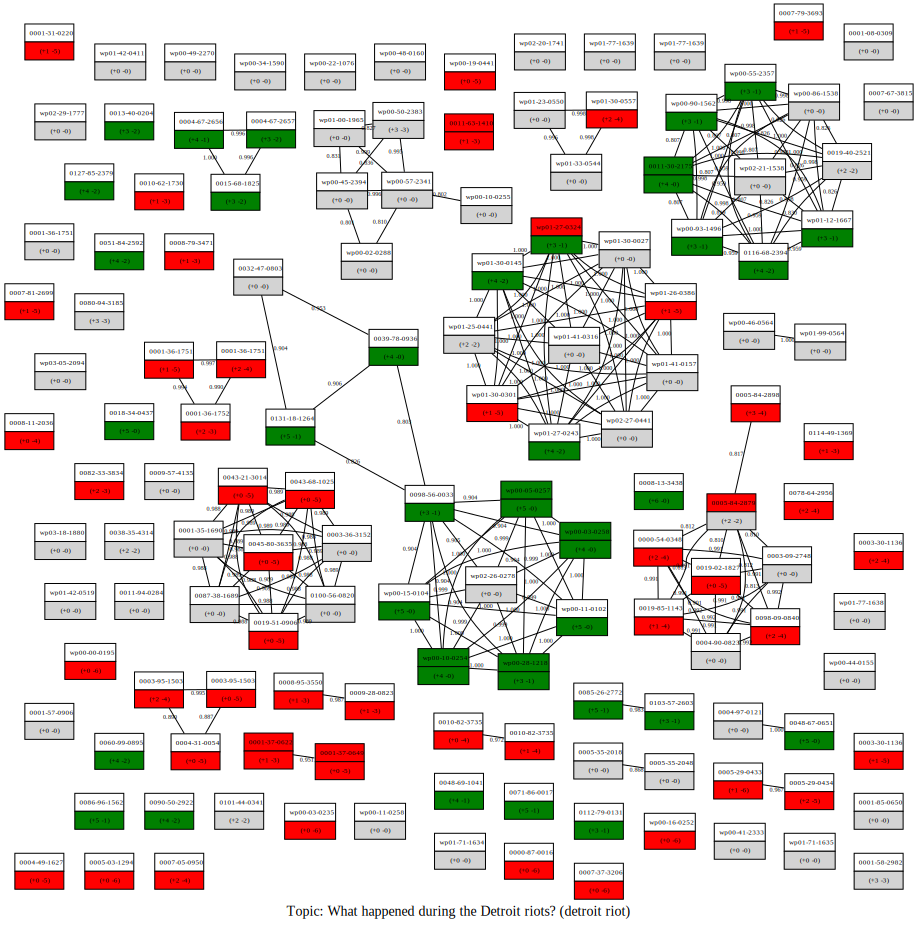

In [21]:
graph_dot

In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

In [2]:

def f(x):
    return x

In [3]:
interact(f, x=10);


10

In [27]:
interact(f, x='Hi there!');

'Hi there!'

In [28]:
widgets.IntSlider(min=-10,max=30,step=1,value=10)